# BTC Option Volatility Scalping with tail-risk hedged

## Introduction
This notebook develops and tests a volatility–scalping strategy on Bitcoin options.  
The workflow begins by benchmarking implied volatility against forward-looking 30-day realized moments — variance, skewness, and excess kurtosis — to identify systematic mispricings.  
Insights from these diagnostics guide the design of a scalping rule, which is then evaluated through a backtest.

## Workflow
1. **Data Diagnostics**  
   - Compare implied vs. realized volatility and higher moments (skew, kurtosis).  
   - Assess the stability of these relationships across time.  

2. **Strategy Design**  
   - Construct trading rules based on observed biases between implied and realized moments.  
   - Define regime multipliers and entry/exit logic.  

3. **Backtesting**  
   - **Train period**: 2021-01-01 → 2024-01-01  
   - **Test period**: 2024-01-01 → 2025-09-26 (code was set to be yesterday of present date)  
   - Evaluate PnL, APR, MDD, Calmar, and trade statistics.  

## Objective
The aim is to validate whether systematic differences between implied and realized distributions can be exploited through option volatility scalping, and whether performance generalizes out-of-sample.

---



VOL — Forward 30D Realized Volatility (Summary Metrics)
Observations                            :  984.000000
Mean DVOL (%)                           :  70.431961
Mean realized vol (%)                   :  58.104138
Bias (realized − dvol) (pts)            : -12.327824
MAE (pts)                               :  18.659540
RMSE (pts)                              :  22.208491
MAPE (%)                                :  37.895560
Corr(DVOL, Realized)                    :  0.593398
Hit-rate (±5.0 pts) %                   :  10.873984

--------------------------------------------------------------------------------
OLS: Realized Vol (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:       realized_30d_fwd   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least S

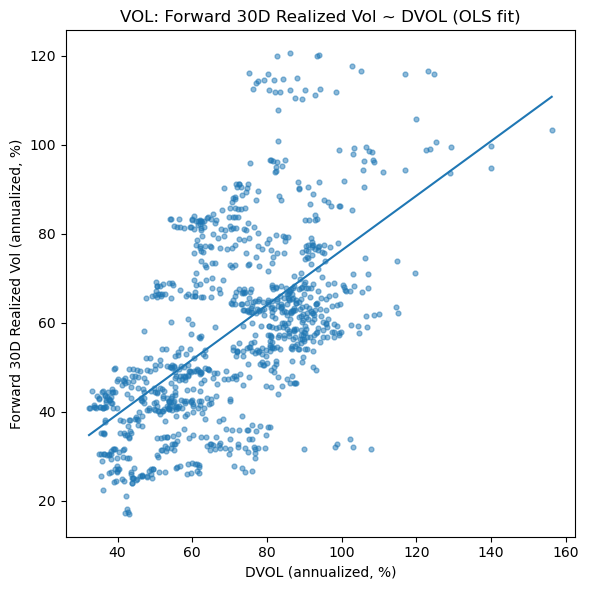

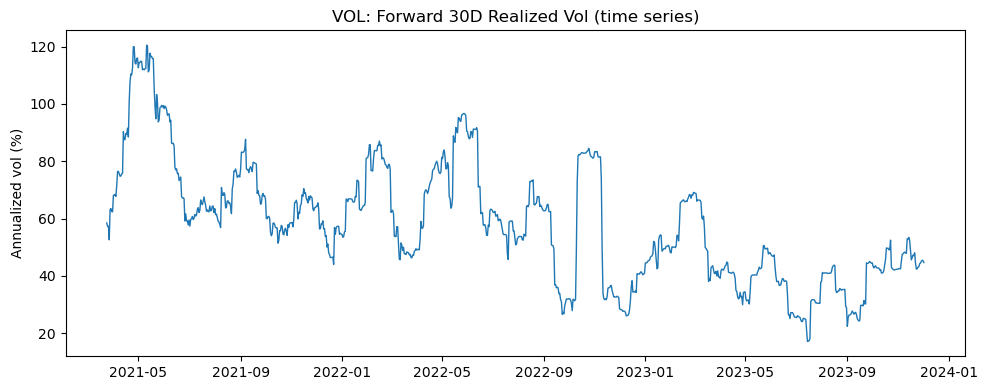


SKEW — Forward 30D Realized Skewness (Summary Metrics)
Observations                            :  984.000000
Mean realized skew                      : -0.000436
MAE vs 0                                :  0.674900
Hit-rate vs 0 (±0.5) %                  :  47.865854

--------------------------------------------------------------------------------
OLS: Realized Skew (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                              OLS Regression Results                             
Dep. Variable:     realized_30d_fwd_skew   R-squared:                       0.034
Model:                               OLS   Adj. R-squared:                  0.033
Method:                    Least Squares   F-statistic:                     34.32
Date:                   Fri, 26 Sep 2025   Prob (F-statistic):           6.39e-09
Time:                           03:43:11   Log-Likelihood:                -1260.7
No. Observations:                    984  

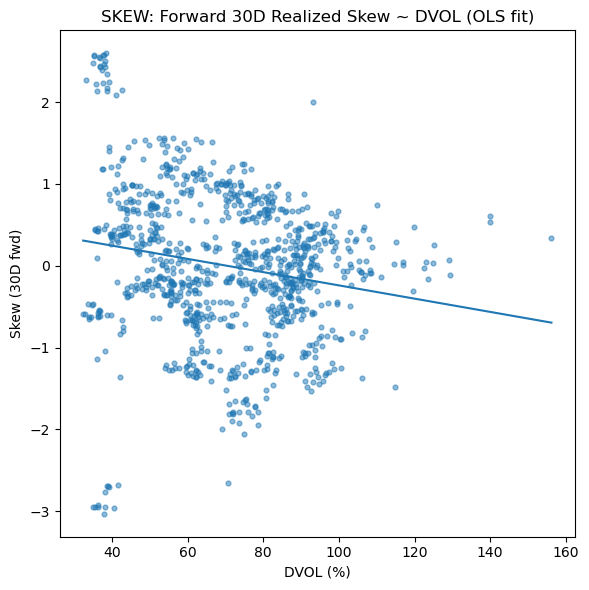

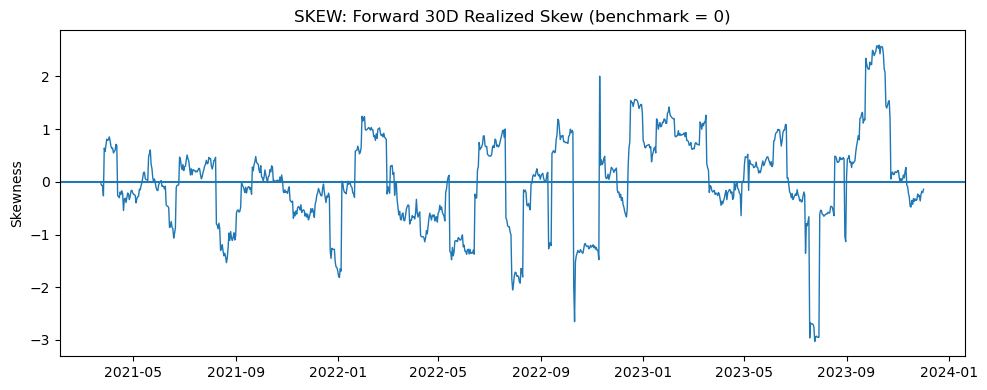


EXKURT — Forward 30D Realized Excess Kurtosis (Summary Metrics)
Observations                            :  984.000000
Mean realized excess kurtosis           :  2.024656
MAE vs 0                                :  2.140063
Hit-rate vs 0 (±1.0) %                  :  45.020325

--------------------------------------------------------------------------------
OLS: Realized Excess Kurtosis (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                               OLS Regression Results                              
Dep. Variable:     realized_30d_fwd_exkurt   R-squared:                       0.168
Model:                                 OLS   Adj. R-squared:                  0.167
Method:                      Least Squares   F-statistic:                     198.1
Date:                     Fri, 26 Sep 2025   Prob (F-statistic):           4.00e-41
Time:                             03:43:11   Log-Likelihood:                -2158.4
No. Observ

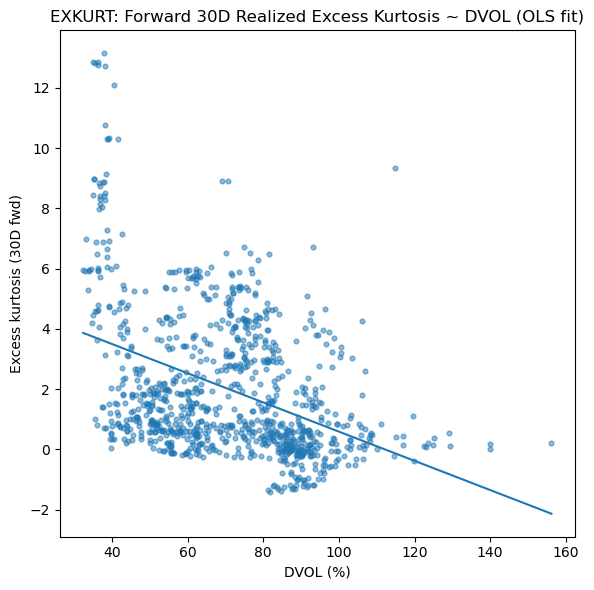

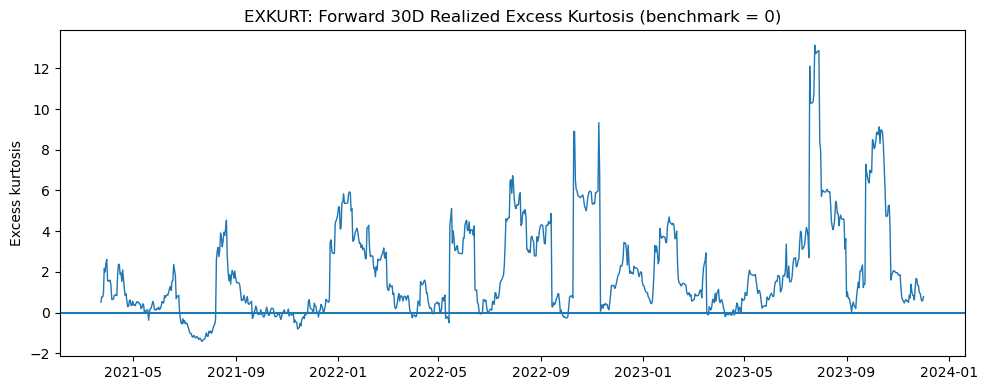

In [4]:
# ========================== DVOL vs Forward 30D Moments ==========================
# Requirements: pandas, numpy, requests, yfinance, statsmodels, matplotlib
# =================================================================================

import io
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")

# ---------------- Config ----------------
ANNUALIZER = np.sqrt(365)     # use sqrt(252) if you want trading-day annualization
START_TRAIN, END_TRAIN = "2021-01-01", "2024-01-01"
WINDOW_DAYS = 30
HIT_BAND = 5.0                # +/- vol points for DVOL hit-rate

# Moment hit-band configs (for quick KPIs)
SKEW_HIT_BAND = 0.5           # abs(skew - 0) <= 0.5
EXKURT_HIT_BAND = 1.0         # abs(excess_kurt - 0) <= 1.0

# Report switches
INCLUDE_PEARSON_KURT = False  # set True to also report Pearson kurtosis moment
# ---------------------------------------


# ---------------- Loaders ----------------
def load_dvol_btc_from_cdd(start=None, end=None):
    url = "https://www.cryptodatadownload.com/cdd/DeriBit_volatility_OHLC_BTC.csv"
    r = requests.get(url, timeout=30); r.raise_for_status()
    raw = r.text.splitlines()
    start_idx = next(i for i, ln in enumerate(raw) if ln.lower().startswith("date,"))
    df = pd.read_csv(io.StringIO("\n".join(raw[start_idx:])))
    df["date"] = pd.to_datetime(df["date"], utc=True).dt.tz_convert(None).dt.normalize()
    df = df.rename(columns={"close":"dvol"})[["date","dvol"]].sort_values("date")
    if start is not None:
        start = pd.to_datetime(start).tz_localize(None).normalize()
        df = df[df["date"] >= start]
    if end is not None:
        end = pd.to_datetime(end).tz_localize(None).normalize()
        df = df[df["date"] <= end]
    return df.reset_index(drop=True)


def load_btc_close_from_yahoo(start=None, end=None):
    btc = yf.download("BTC-USD", start=start, end=end, interval="1d",
                      auto_adjust=False, progress=False)
    btc = (btc[["Close"]]
           .rename(columns={"Close":"close"})
           .reset_index()
           .rename(columns={"Date":"date"}))
    btc["date"] = pd.to_datetime(btc["date"], utc=True).dt.tz_convert(None).dt.normalize()
    return btc.sort_values("date")[["date","close"]].reset_index(drop=True)


# ---------------- Realized metrics (forward alignment) ----------------
def compute_forward_30d_realized(close_df, window_days=30, annualizer=np.sqrt(365)):
    """
    Forward-aligned 30D realized volatility:
    value at date t uses returns from (t+1 ... t+window_days).
    """
    df = close_df[['date','close']].copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    df['ret'] = np.log(df['close'] / df['close'].shift(1))
    ret = df.set_index('date')['ret'].dropna()

    fwd_std = ret.iloc[::-1].rolling(window_days).std().iloc[::-1] * annualizer * 100.0
    out = fwd_std.reset_index()
    out.columns = ['date','realized_30d_fwd']
    return out


def compute_forward_30d_moments(close_df, window_days=30):
    """
    Forward-aligned 30D realized skewness/kurtosis:
      - skew: Fisher-Pearson skewness (normal benchmark = 0)
      - exkurt: excess kurtosis (normal benchmark = 0)
      - kurtosis: Pearson kurtosis = exkurt + 3 (normal benchmark = 3)
    """
    df = close_df[['date','close']].copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    df['ret'] = np.log(df['close'] / df['close'].shift(1))

    ret = df.set_index('date')['ret'].dropna()
    ret_rev = ret.iloc[::-1]

    fwd_skew     = ret_rev.rolling(window_days).skew().iloc[::-1]
    fwd_exkurt   = ret_rev.rolling(window_days).kurt().iloc[::-1]   # excess kurtosis
    fwd_kurtosis = fwd_exkurt + 3.0

    out = pd.concat(
        [
            fwd_skew.rename('realized_30d_fwd_skew'),
            fwd_exkurt.rename('realized_30d_fwd_exkurt'),
            fwd_kurtosis.rename('realized_30d_fwd_kurtosis'),
        ],
        axis=1
    ).reset_index()
    out = out.rename(columns={'index':'date'})
    return out


# ---------------- Run pipeline ----------------
# 1) Load data
dvol   = load_dvol_btc_from_cdd(start=START_TRAIN, end=END_TRAIN)
btc_px = load_btc_close_from_yahoo(start=START_TRAIN, end=END_TRAIN)

# 2) Forward 30D realized vol
rv = compute_forward_30d_realized(btc_px, WINDOW_DAYS, ANNUALIZER)

# 3) Forward 30D realized skew/kurt
moms = compute_forward_30d_moments(btc_px, WINDOW_DAYS)

# 4) Align & evaluate (vol side)
df = dvol.merge(rv, on="date", how="inner").dropna(subset=["dvol","realized_30d_fwd"]).copy()
df["err"] = df["realized_30d_fwd"] - df["dvol"]
df["abs_err"] = df["err"].abs()
df["ape"] = (df["abs_err"] / df["realized_30d_fwd"].replace(0, np.nan)) * 100.0
df["hit"] = (df["abs_err"] <= HIT_BAND).astype(int)

summary = {
    "n": int(len(df)),
    "mean_dvol": df["dvol"].mean(),
    "mean_realized": df["realized_30d_fwd"].mean(),
    "bias (realized - dvol)": df["err"].mean(),
    "MAE": df["abs_err"].mean(),
    "RMSE": np.sqrt((df["err"]**2).mean()),
    "MAPE_%": df["ape"].mean(),
    "corr": df["dvol"].corr(df["realized_30d_fwd"]),
    f"hit_rate_%(±{HIT_BAND} pts)": 100*df["hit"].mean(),
}

# 5) OLS: Realized VOL ~ DVOL
ols_vol_dvol = sm.OLS(df["realized_30d_fwd"], sm.add_constant(df["dvol"])).fit()

# 6) Join moments (with DVOL for regressions)
df_mom = dvol.merge(moms, on="date", how="inner").dropna(subset=[
    "dvol","realized_30d_fwd_skew","realized_30d_fwd_exkurt","realized_30d_fwd_kurtosis"
])

# Moment deviations vs normal
skew_err   = df_mom["realized_30d_fwd_skew"]     - 0.0
exkurt_err = df_mom["realized_30d_fwd_exkurt"]   - 0.0
kurt_err   = df_mom["realized_30d_fwd_kurtosis"] - 3.0

mom_summary = {
    "n": int(len(df_mom)),
    "mean_realized_skew":   df_mom["realized_30d_fwd_skew"].mean(),
    "mean_realized_exkurt": df_mom["realized_30d_fwd_exkurt"].mean(),
    "mean_realized_kurt":   df_mom["realized_30d_fwd_kurtosis"].mean(),
    "MAE_skew_vs_0":        skew_err.abs().mean(),
    "MAE_exkurt_vs_0":      exkurt_err.abs().mean(),
    "MAE_kurt_vs_3":        kurt_err.abs().mean(),
    f"hit_skew_%(±{SKEW_HIT_BAND})":    100*(skew_err.abs()   <= SKEW_HIT_BAND).mean(),
    f"hit_exkurt_%(±{EXKURT_HIT_BAND})":100*(exkurt_err.abs() <= EXKURT_HIT_BAND).mean(),
}

# ================= OLS on all moments =================
ols_skew_dvol   = sm.OLS(df_mom["realized_30d_fwd_skew"],    sm.add_constant(df_mom["dvol"])).fit()
ols_exkurt_dvol = sm.OLS(df_mom["realized_30d_fwd_exkurt"],  sm.add_constant(df_mom["dvol"])).fit()
ols_kurt_dvol   = sm.OLS(df_mom["realized_30d_fwd_kurtosis"],sm.add_constant(df_mom["dvol"])).fit()

# ================= Sequential Moment Reporter =================
# Prints metrics & OLS, then shows the two plots for each moment, in order.

def _print_metrics_block(title, kv):
    print("\n" + "="*80)
    print(title)
    print("="*80)
    for k, v in kv.items():
        if isinstance(v, (int, float, np.floating)):
            print(f"{k:40s}: {v: .6f}")
        else:
            print(f"{k:40s}: {v}")

def _print_ols_block(title, res):
    print("\n" + "-"*80)
    print(title)
    print("-"*80)
    print(res.summary())

def _scatter_with_fit(x, y, title, xlab, ylab, ols_fit):
    plt.figure(figsize=(6,6))
    plt.scatter(x, y, s=12, alpha=0.5)
    xx = np.linspace(np.nanmin(x), np.nanmax(x), 200)
    yy = ols_fit.params[0] + ols_fit.params[1] * xx
    plt.plot(xx, yy)  # OLS fit
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.tight_layout()
    plt.show()

def _timeseries_with_baseline(date, series, baseline, title, ylab):
    plt.figure(figsize=(10,4))
    plt.plot(date, series, lw=1)
    if baseline is not None:
        plt.axhline(baseline)
    plt.title(title)
    plt.ylabel(ylab)
    plt.xlabel("")
    plt.tight_layout()
    plt.show()


# -------------------- 1) VOL --------------------
vol_metrics = {
    "Observations": summary["n"],
    "Mean DVOL (%)": summary["mean_dvol"],
    "Mean realized vol (%)": summary["mean_realized"],
    "Bias (realized − dvol) (pts)": summary["bias (realized - dvol)"],
    "MAE (pts)": summary["MAE"],
    "RMSE (pts)": summary["RMSE"],
    "MAPE (%)": summary["MAPE_%"],
    "Corr(DVOL, Realized)": summary["corr"],
    f"Hit-rate (±{HIT_BAND} pts) %": summary[f"hit_rate_%(±{HIT_BAND} pts)"],
}

_print_metrics_block("VOL — Forward 30D Realized Volatility (Summary Metrics)", vol_metrics)
_print_ols_block("OLS: Realized Vol (30D fwd) ~ DVOL", ols_vol_dvol)

_scatter_with_fit(
    x=df["dvol"].values,
    y=df["realized_30d_fwd"].values,
    title="VOL: Forward 30D Realized Vol ~ DVOL (OLS fit)",
    xlab="DVOL (annualized, %)",
    ylab="Forward 30D Realized Vol (annualized, %)",
    ols_fit=ols_vol_dvol
)
_timeseries_with_baseline(
    date=df["date"],
    series=df["realized_30d_fwd"],
    baseline=None,
    title="VOL: Forward 30D Realized Vol (time series)",
    ylab="Annualized vol (%)"
)

# -------------------- 2) SKEW --------------------
skew_metrics = {
    "Observations": mom_summary["n"],
    "Mean realized skew": mom_summary["mean_realized_skew"],
    "MAE vs 0": mom_summary["MAE_skew_vs_0"],
    f"Hit-rate vs 0 (±{SKEW_HIT_BAND}) %": mom_summary[f"hit_skew_%(±{SKEW_HIT_BAND})"],
}
_print_metrics_block("SKEW — Forward 30D Realized Skewness (Summary Metrics)", skew_metrics)
_print_ols_block("OLS: Realized Skew (30D fwd) ~ DVOL", ols_skew_dvol)

_scatter_with_fit(
    x=df_mom["dvol"].values,
    y=df_mom["realized_30d_fwd_skew"].values,
    title="SKEW: Forward 30D Realized Skew ~ DVOL (OLS fit)",
    xlab="DVOL (%)",
    ylab="Skew (30D fwd)",
    ols_fit=ols_skew_dvol
)
_timeseries_with_baseline(
    date=df_mom["date"],
    series=df_mom["realized_30d_fwd_skew"],
    baseline=0.0,
    title="SKEW: Forward 30D Realized Skew (benchmark = 0)",
    ylab="Skewness"
)

# -------------------- 3) EXCESS KURTOSIS --------------------
exkurt_metrics = {
    "Observations": mom_summary["n"],
    "Mean realized excess kurtosis": mom_summary["mean_realized_exkurt"],
    "MAE vs 0": mom_summary["MAE_exkurt_vs_0"],
    f"Hit-rate vs 0 (±{EXKURT_HIT_BAND}) %": mom_summary[f"hit_exkurt_%(±{EXKURT_HIT_BAND})"],
}
_print_metrics_block("EXKURT — Forward 30D Realized Excess Kurtosis (Summary Metrics)", exkurt_metrics)
_print_ols_block("OLS: Realized Excess Kurtosis (30D fwd) ~ DVOL", ols_exkurt_dvol)

_scatter_with_fit(
    x=df_mom["dvol"].values,
    y=df_mom["realized_30d_fwd_exkurt"].values,
    title="EXKURT: Forward 30D Realized Excess Kurtosis ~ DVOL (OLS fit)",
    xlab="DVOL (%)",
    ylab="Excess kurtosis (30D fwd)",
    ols_fit=ols_exkurt_dvol
)
_timeseries_with_baseline(
    date=df_mom["date"],
    series=df_mom["realized_30d_fwd_exkurt"],
    baseline=0.0,
    title="EXKURT: Forward 30D Realized Excess Kurtosis (benchmark = 0)",
    ylab="Excess kurtosis"
)

# -------------------- 4) (Optional) Pearson KURTOSIS --------------------
if INCLUDE_PEARSON_KURT:
    kurt_metrics = {
        "Observations": mom_summary["n"],
        "Mean realized kurtosis": mom_summary["mean_realized_kurt"],
        "MAE vs 3": mom_summary["MAE_kurt_vs_3"],
    }
    _print_metrics_block("KURT — Forward 30D Realized Kurtosis (Pearson) (Summary Metrics)", kurt_metrics)
    _print_ols_block("OLS: Realized Kurtosis (Pearson, 30D fwd) ~ DVOL", ols_kurt_dvol)

    _scatter_with_fit(
        x=df_mom["dvol"].values,
        y=df_mom["realized_30d_fwd_kurtosis"].values,
        title="KURT: Forward 30D Realized Kurtosis (Pearson) ~ DVOL (OLS fit)",
        xlab="DVOL (%)",
        ylab="Kurtosis (30D fwd)",
        ols_fit=ols_kurt_dvol
    )
    _timeseries_with_baseline(
        date=df_mom["date"],
        series=df_mom["realized_30d_fwd_kurtosis"],
        baseline=3.0,
        title="KURT: Forward 30D Realized Kurtosis (benchmark = 3)",
        ylab="Kurtosis"
    )


## Benchmarking Implied vs. Forward 30D Realized Moments

### Volatility (Realized vs DVOL)
- **Observations**: 984  
- **Mean DVOL**: 70.43%  
- **Mean realized vol**: 58.10%  
- **Bias (realized − dvol)**: -12.33 pts → implied systematically **overstates** realized vol  
- **Error metrics**: MAE = 18.66 pts, RMSE = 22.21 pts, MAPE = 37.9%  
- **Correlation (DVOL, Realized)**: 0.59  
- **Hit-rate (±5 pts)**: ~10.9%  
- **OLS regression**:  
  $ \text{Realized Vol} = 14.84 + 0.61 \times \text{DVOL}, \quad R^2 = 0.35 $  
  DVOL is positively related but explains only ~35% of realized variation.

---

### Skewness
- **Observations**: 984  
- **Mean realized skew**: ~0 (–0.0004)  
- **MAE vs 0**: 0.675  
- **Hit-rate vs 0 (±0.5)**: ~47.9%  
- **OLS regression**:  
  $ \text{Realized Skew} = 0.57 - 0.008 \times \text{DVOL}, \quad R^2 = 0.03 $  
  Relationship is weak; realized skew drifts slightly negative as DVOL increases.

---

### Excess Kurtosis
- **Observations**: 984  
- **Mean realized excess kurtosis**: 2.02 (non-Gaussian tails)  
- **MAE vs 0**: 2.14  
- **Hit-rate vs 0 (±1.0)**: ~45.0%  
- **OLS regression**:  
  $ \text{Realized ExKurt} = 5.44 - 0.048 \times \text{DVOL}, \quad R^2 = 0.17 $  
  Higher DVOL is associated with lower forward kurtosis, but explanatory power is limited.

---

**Takeaway:**  
- Implied volatility consistently **overprices** future realized vol.  
- Skewness and kurtosis forecasts from DVOL are weak, with low R² values.  
- These biases motivate scalping strategies that fade implied premia, particularly in high-volatility regimes.



==== Regime breakdown (DVOL terciles) ====
dvol_regime  mean_dvol  mean_realized       bias       mae      rmse     corr  hit_rate
        Low  47.915274      42.373854  -5.541420 11.249677 13.414667 0.391879  0.204268
        Mid  70.694012      61.291588  -9.402425 19.084219 22.179624 0.104081  0.079027
       High  92.753853      70.675581 -22.078272 25.664788 28.438144 0.310778  0.042813


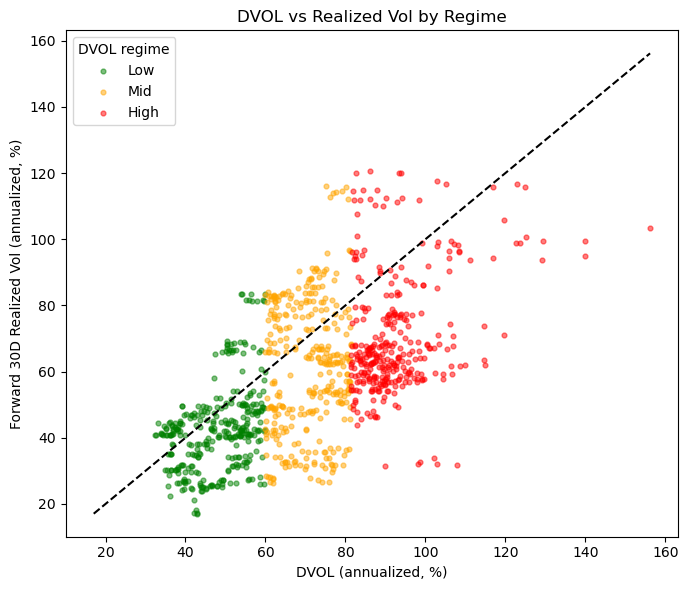


####################################################################################################
# Regime: Low
####################################################################################################

Low — VOL (Summary Metrics)
Observations                            :  328.000000
Mean DVOL (%)                           :  47.915274
Mean realized vol (%)                   :  42.373854
Bias (realized − dvol) (pts)            : -5.541420
MAE (pts)                               :  11.249677
RMSE (pts)                              :  13.414667
MAPE (%)                                :  31.334971
Corr(DVOL, Realized)                    :  0.391879
Hit-rate (±5.0 pts) %                   :  20.426829

--------------------------------------------------------------------------------
OLS (Low): Realized Vol (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                        

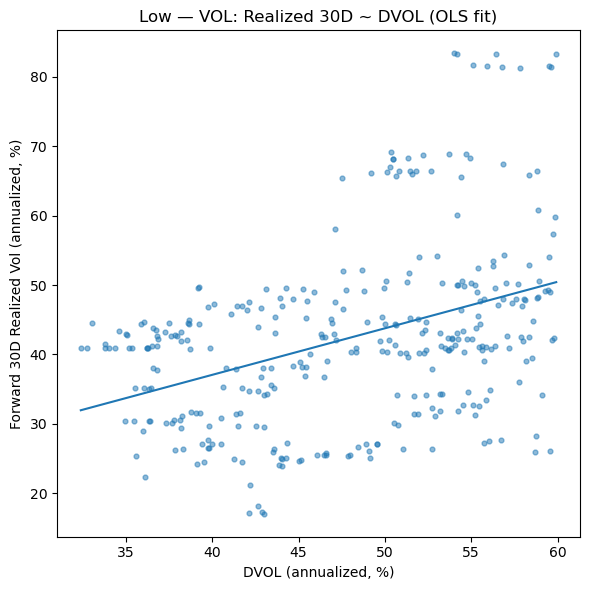

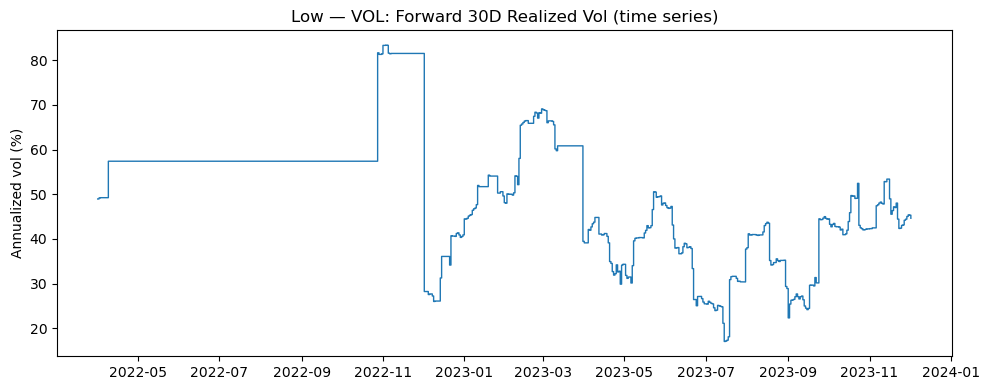


Low — SKEW (Summary Metrics)
Observations                            :  328.000000
Mean realized skew                      :  0.295710
MAE vs 0                                :  0.817473
Hit-rate vs 0 (±0.5) %                  :  46.341463

--------------------------------------------------------------------------------
OLS (Low): Realized Skew (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.396
Date:                Fri, 26 Sep 2025   Prob (F-statistic):              0.238
Time:                        03:43:11   Log-Likelihood:                -480.32
No. Observations:                 328   AIC:                             964.6
D

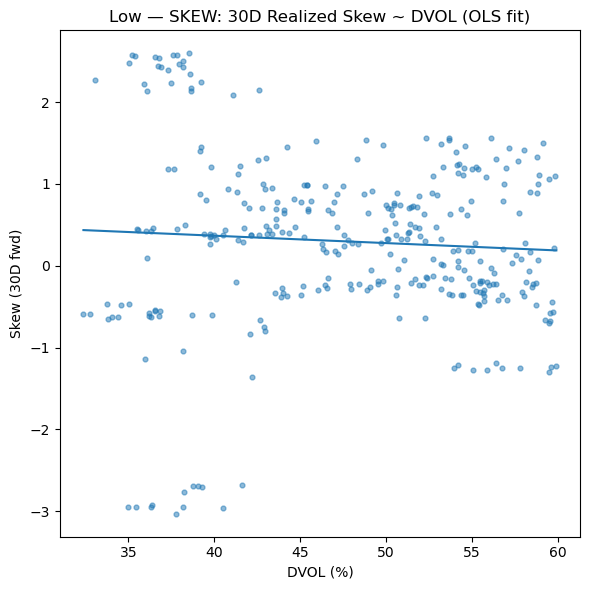

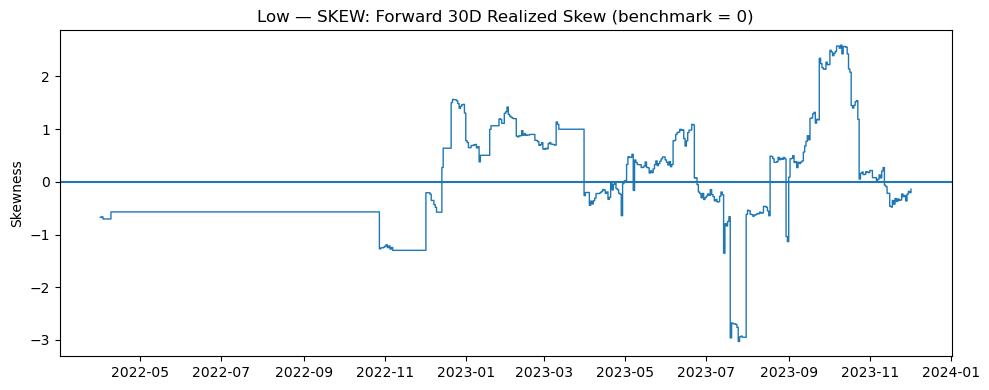


Low — EXKURT (Summary Metrics)
Observations                            :  328.000000
Mean realized excess kurtosis           :  2.882814
MAE vs 0                                :  2.890431
Hit-rate vs 0 (±1.0) %                  :  32.317073

--------------------------------------------------------------------------------
OLS (Low): Realized Excess Kurtosis (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     123.4
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           1.57e-24
Time:                        03:43:12   Log-Likelihood:                -758.06
No. Observations:                 328   AIC:                       

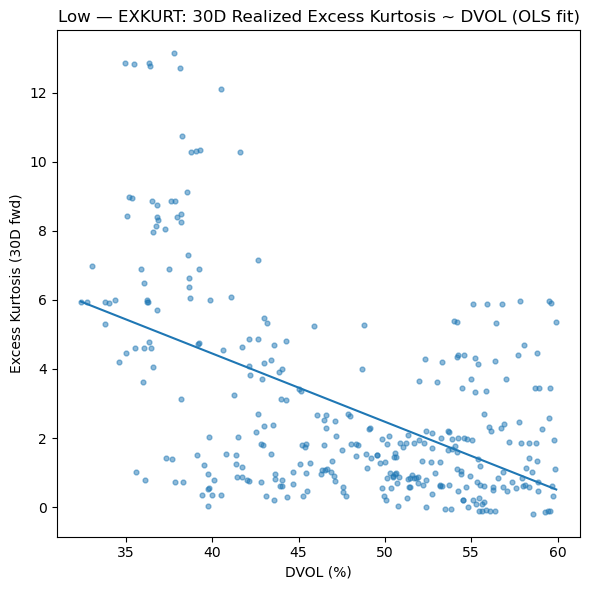

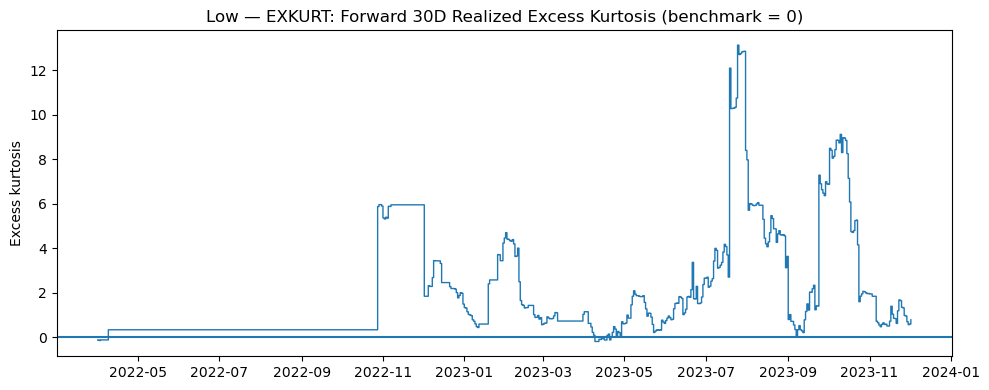


####################################################################################################
# Regime: Mid
####################################################################################################

Mid — VOL (Summary Metrics)
Observations                            :  329.000000
Mean DVOL (%)                           :  70.694012
Mean realized vol (%)                   :  61.291588
Bias (realized − dvol) (pts)            : -9.402425
MAE (pts)                               :  19.084219
RMSE (pts)                              :  22.179624
MAPE (%)                                :  40.517453
Corr(DVOL, Realized)                    :  0.104081
Hit-rate (±5.0 pts) %                   :  7.902736

--------------------------------------------------------------------------------
OLS (Mid): Realized Vol (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                         

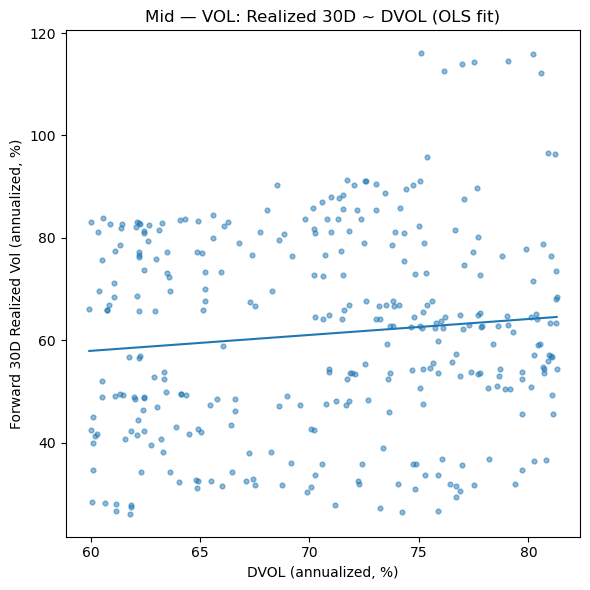

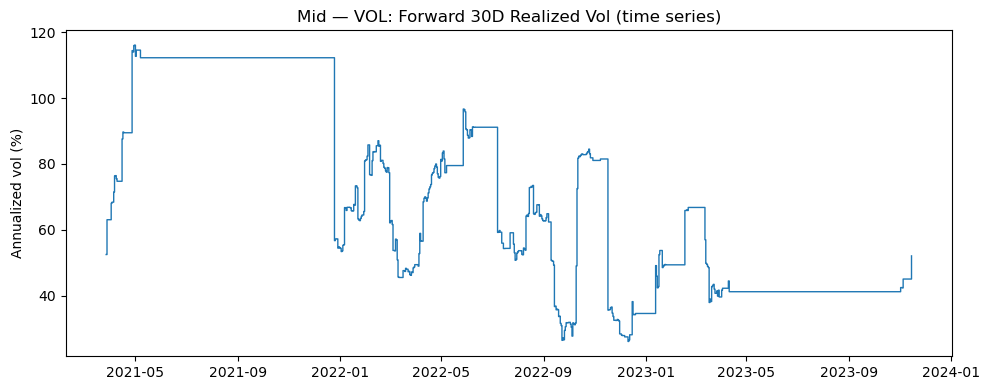


Mid — SKEW (Summary Metrics)
Observations                            :  329.000000
Mean realized skew                      : -0.138064
MAE vs 0                                :  0.742512
Hit-rate vs 0 (±0.5) %                  :  34.346505

--------------------------------------------------------------------------------
OLS (Mid): Realized Skew (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.375
Date:                Fri, 26 Sep 2025   Prob (F-statistic):              0.242
Time:                        03:43:12   Log-Likelihood:                -426.95
No. Observations:                 329   AIC:                             857.9
D

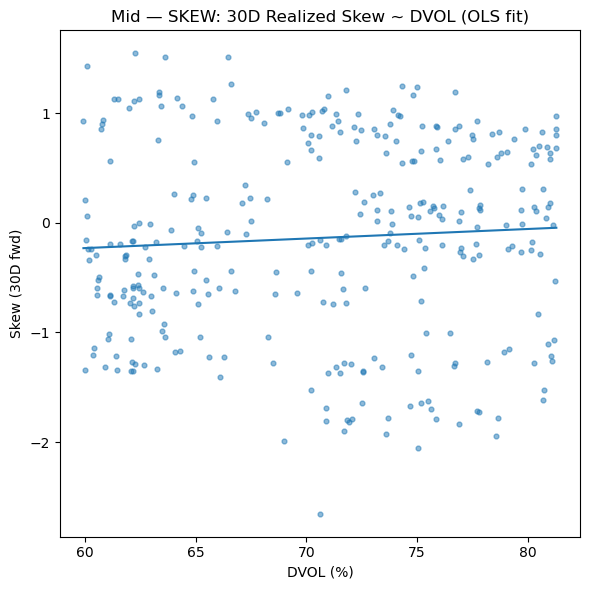

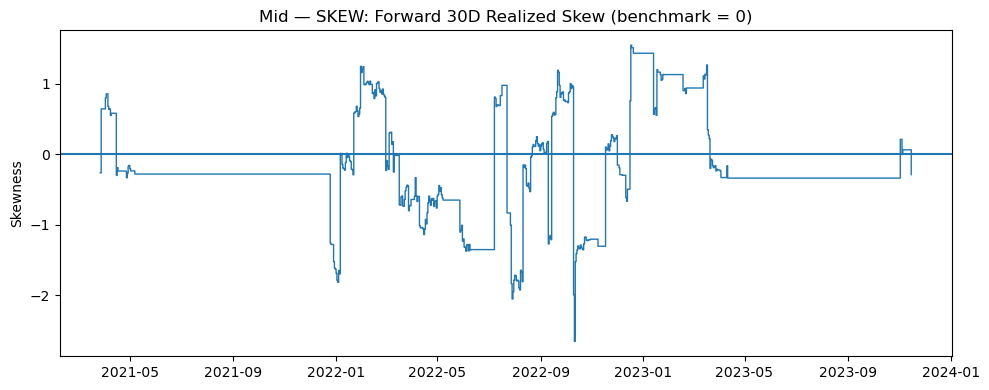


Mid — EXKURT (Summary Metrics)
Observations                            :  329.000000
Mean realized excess kurtosis           :  2.473121
MAE vs 0                                :  2.489255
Hit-rate vs 0 (±1.0) %                  :  34.954407

--------------------------------------------------------------------------------
OLS (Mid): Realized Excess Kurtosis (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.590
Date:                Fri, 26 Sep 2025   Prob (F-statistic):             0.0590
Time:                        03:43:12   Log-Likelihood:                -687.65
No. Observations:                 329   AIC:                       

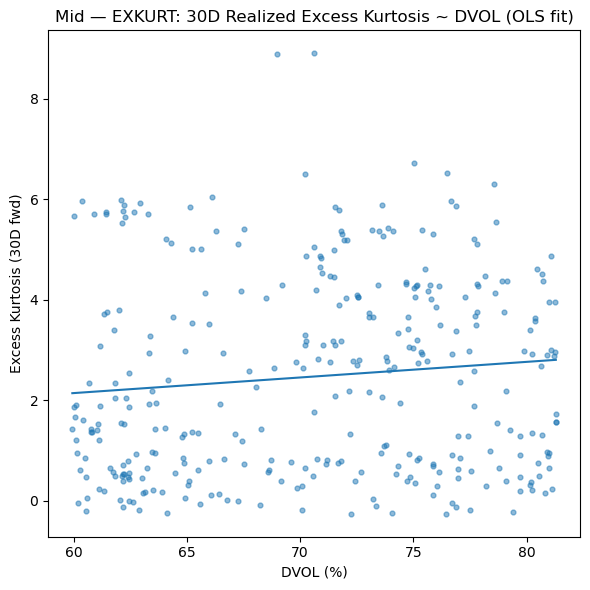

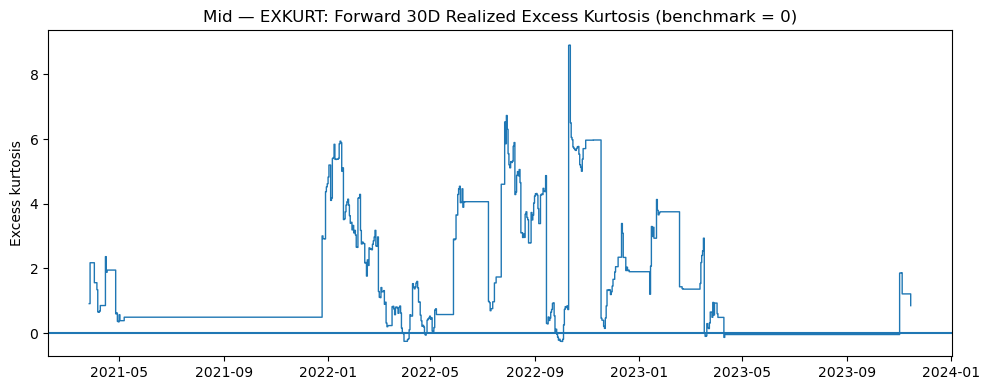


####################################################################################################
# Regime: High
####################################################################################################

High — VOL (Summary Metrics)
Observations                            :  327.000000
Mean DVOL (%)                           :  92.753853
Mean realized vol (%)                   :  70.675581
Bias (realized − dvol) (pts)            : -22.078272
MAE (pts)                               :  25.664788
RMSE (pts)                              :  28.438144
MAPE (%)                                :  41.838284
Corr(DVOL, Realized)                    :  0.310778
Hit-rate (±5.0 pts) %                   :  4.281346

--------------------------------------------------------------------------------
OLS (High): Realized Vol (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                     

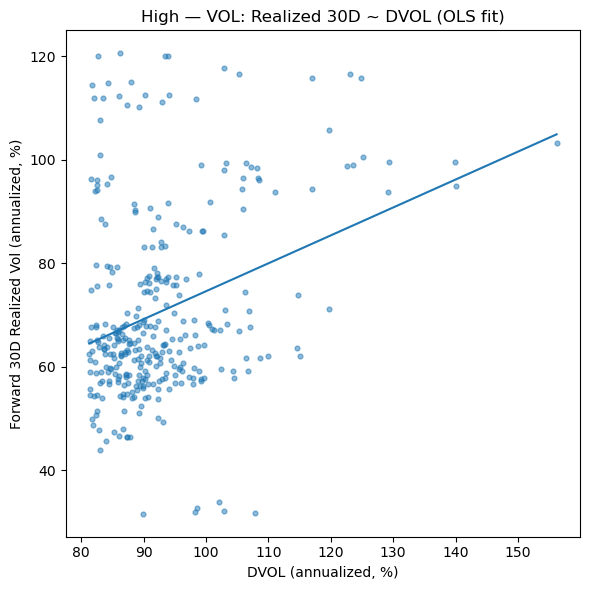

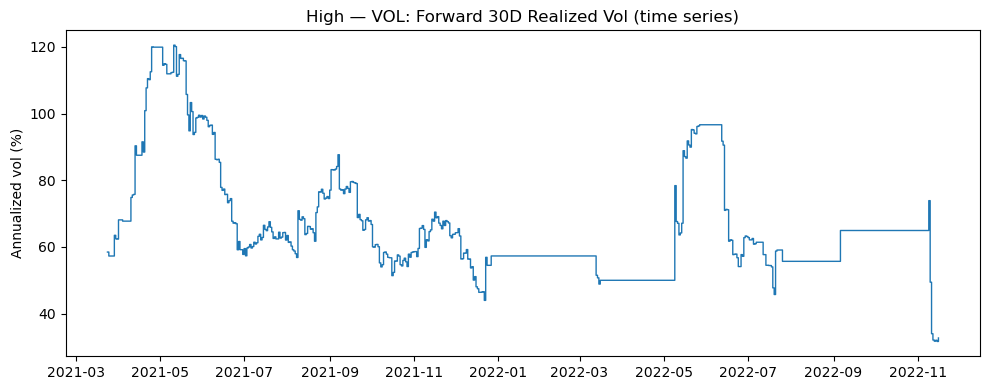


High — SKEW (Summary Metrics)
Observations                            :  327.000000
Mean realized skew                      : -0.159017
MAE vs 0                                :  0.463864
Hit-rate vs 0 (±0.5) %                  :  62.996942

--------------------------------------------------------------------------------
OLS (High): Realized Skew (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.632
Date:                Fri, 26 Sep 2025   Prob (F-statistic):              0.106
Time:                        03:43:13   Log-Likelihood:                -284.56
No. Observations:                 327   AIC:                             573.1

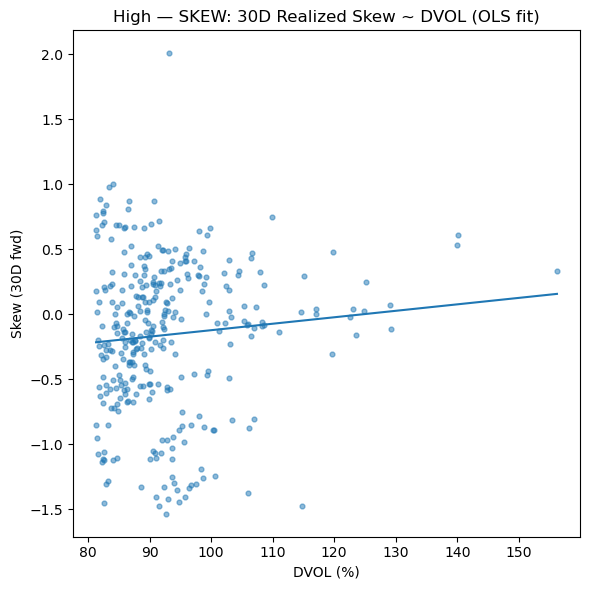

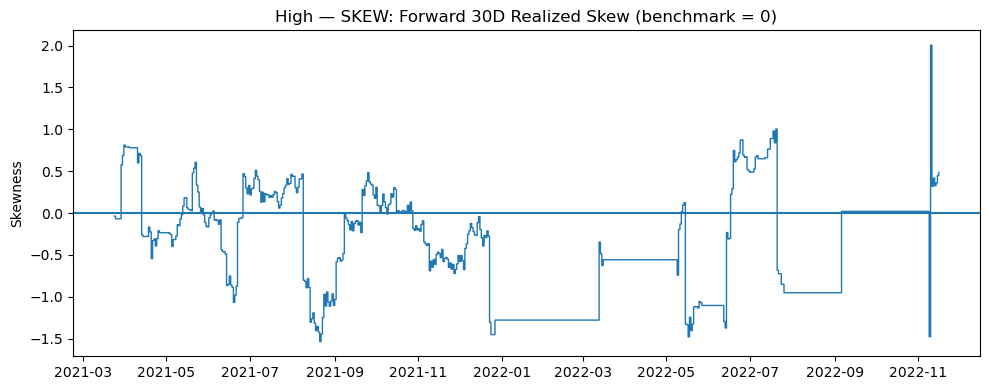


High — EXKURT (Summary Metrics)
Observations                            :  327.000000
Mean realized excess kurtosis           :  0.712665
MAE vs 0                                :  1.036074
Hit-rate vs 0 (±1.0) %                  :  67.889908

--------------------------------------------------------------------------------
OLS (High): Realized Excess Kurtosis (30D fwd) ~ DVOL
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1761
Date:                Fri, 26 Sep 2025   Prob (F-statistic):              0.675
Time:                        03:43:13   Log-Likelihood:                -594.99
No. Observations:                 327   AIC:                     

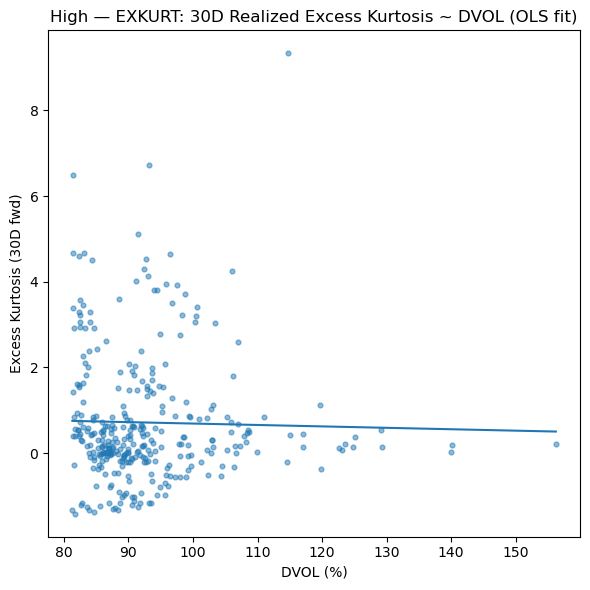

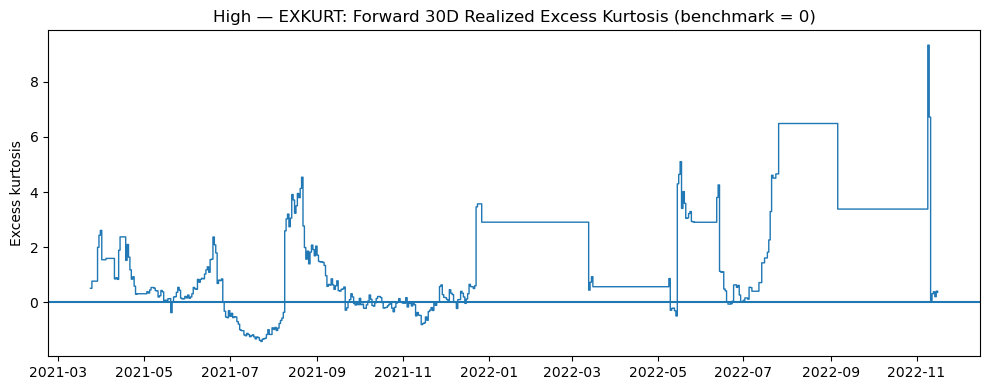

In [5]:
# ---------------- Regime analysis (step-style timeseries) ----------------
# Helper: step-series (zero-order hold) on a regular daily grid
def _as_step_series(date, series, freq="D"):
    s = pd.Series(series.values, index=pd.to_datetime(date.values)).sort_index()
    if s.empty:
        return np.array([]), np.array([])
    full_idx = pd.date_range(s.index.min(), s.index.max(), freq=freq)
    s_full = s.reindex(full_idx).ffill()
    first_valid = s.first_valid_index()
    if first_valid is not None:
        s_full.loc[:first_valid] = s_full.loc[:first_valid].where(~s_full.loc[:first_valid].isna(), np.nan)
    return s_full.index.to_pydatetime(), s_full.values

def _timeseries_with_baseline(date, series, baseline, title, ylab):
    x_step, y_step = _as_step_series(date, series, freq="D")
    plt.figure(figsize=(10,4))
    plt.plot(x_step, y_step, drawstyle="steps-post", lw=1)
    if baseline is not None:
        plt.axhline(baseline)
    plt.title(title)
    plt.ylabel(ylab)
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

# Split into terciles of DVOL
low_q  = df['dvol'].quantile(1/3)
high_q = df['dvol'].quantile(2/3)
df['dvol_regime'] = pd.qcut(df['dvol'], 3, labels=['Low','Mid','High'])
regime_stats = (
    df.groupby('dvol_regime')
      .agg(mean_dvol=('dvol','mean'),
           mean_realized=('realized_30d_fwd','mean'),
           bias=('err','mean'),
           mae=('abs_err','mean'),
           rmse=('err', lambda x: np.sqrt((x**2).mean())),
           corr=('dvol', lambda x: x.corr(df.loc[x.index,'realized_30d_fwd'])),
           hit_rate=('hit','mean'))
      .reset_index()
)

# Pretty print
print("\n==== Regime breakdown (DVOL terciles) ====")
print(regime_stats.to_string(index=False))

# Optional: scatter plot color-coded by regime (unchanged)
colors = {'Low':'green','Mid':'orange','High':'red'}
plt.figure(figsize=(7,6))
for regime, sub in df.groupby('dvol_regime'):
    plt.scatter(sub['dvol'], sub['realized_30d_fwd'],
                s=12, alpha=0.5, label=regime, c=colors[regime])
mn = df[['dvol','realized_30d_fwd']].min().min()
mx = df[['dvol','realized_30d_fwd']].max().max()
plt.plot([mn,mx],[mn,mx], 'k--')
plt.xlabel("DVOL (annualized, %)")
plt.ylabel("Forward 30D Realized Vol (annualized, %)")
plt.legend(title="DVOL regime")
plt.title("DVOL vs Realized Vol by Regime")
plt.tight_layout()
plt.show()

# ================= Regime-wise re-run (VOL → SKEW → EXKURT per regime) =================

# Helper: safe OLS (skip if too few obs or zero variance)
def _safe_ols(y, X):
    y = np.asarray(y)
    X = np.asarray(X)
    ok = np.isfinite(y) & np.isfinite(X)
    y, X = y[ok], X[ok]
    if y.size < 10 or np.allclose(X, X[0]):   # need enough obs and variation
        return None
    try:
        return sm.OLS(y, sm.add_constant(X)).fit()
    except Exception:
        return None

def _print_or_skip(title, res):
    if res is None:
        print(f"\n{title}\n  (skipped: insufficient variation / too few observations)")
    else:
        _print_ols_block(title, res)

# Map regime labels to df_mom (by date)
df_reg_label = df[["date", "dvol_regime"]]
df_mom_reg = df_mom.merge(df_reg_label, on="date", how="inner")

# Order to report
REG_ORDER = ["Low", "Mid", "High"]

for reg in REG_ORDER:
    print("\n" + "#"*100)
    print(f"# Regime: {reg}")
    print("#"*100)

    # ---------- VOL panel (this regime) ----------
    sub_vol = df.loc[df["dvol_regime"] == reg].copy()
    if sub_vol.empty:
        print(f"(no rows for regime {reg})")
        continue

    # Recompute VOL metrics for the subset
    sub_summary = {
        "n": int(len(sub_vol)),
        "mean_dvol": sub_vol["dvol"].mean(),
        "mean_realized": sub_vol["realized_30d_fwd"].mean(),
        "bias (realized - dvol)": (sub_vol["realized_30d_fwd"] - sub_vol["dvol"]).mean(),
        "MAE": (sub_vol["realized_30d_fwd"] - sub_vol["dvol"]).abs().mean(),
        "RMSE": np.sqrt(((sub_vol["realized_30d_fwd"] - sub_vol["dvol"])**2).mean()),
        "MAPE_%": ((sub_vol["realized_30d_fwd"] - sub_vol["dvol"]).abs() /
                   sub_vol["realized_30d_fwd"].replace(0, np.nan)).mean() * 100.0,
        "corr": sub_vol["dvol"].corr(sub_vol["realized_30d_fwd"]),
        f"hit_rate_%(±{HIT_BAND} pts)": 100.0 *
            ((sub_vol["realized_30d_fwd"] - sub_vol["dvol"]).abs() <= HIT_BAND).mean(),
    }

    # OLS for VOL in subset
    ols_vol_sub = _safe_ols(sub_vol["realized_30d_fwd"].values, sub_vol["dvol"].values)

    # Print VOL metrics + OLS + plots (time-series now step-style)
    vol_metrics_pretty = {
        "Observations": sub_summary["n"],
        "Mean DVOL (%)": sub_summary["mean_dvol"],
        "Mean realized vol (%)": sub_summary["mean_realized"],
        "Bias (realized − dvol) (pts)": sub_summary["bias (realized - dvol)"],
        "MAE (pts)": sub_summary["MAE"],
        "RMSE (pts)": sub_summary["RMSE"],
        "MAPE (%)": sub_summary["MAPE_%"],
        "Corr(DVOL, Realized)": sub_summary["corr"],
        f"Hit-rate (±{HIT_BAND} pts) %": sub_summary[f"hit_rate_%(±{HIT_BAND} pts)"],
    }
    _print_metrics_block(f"{reg} — VOL (Summary Metrics)", vol_metrics_pretty)
    _print_or_skip(f"OLS ({reg}): Realized Vol (30D fwd) ~ DVOL", ols_vol_sub)

    _scatter_with_fit(
        x=sub_vol["dvol"].values,
        y=sub_vol["realized_30d_fwd"].values,
        title=f"{reg} — VOL: Realized 30D ~ DVOL (OLS fit)",
        xlab="DVOL (annualized, %)",
        ylab="Forward 30D Realized Vol (annualized, %)",
        ols_fit=ols_vol_sub if ols_vol_sub is not None else ols_vol_dvol
    )
    _timeseries_with_baseline(
        date=sub_vol["date"],
        series=sub_vol["realized_30d_fwd"],
        baseline=None,
        title=f"{reg} — VOL: Forward 30D Realized Vol (time series)",
        ylab="Annualized vol (%)"
    )

    # ---------- Moments panel (this regime) ----------
    sub_mom = df_mom_reg.loc[df_mom_reg["dvol_regime"] == reg].copy()
    if sub_mom.empty:
        print(f"(no moment rows for regime {reg})")
        continue

    # Errors vs normal
    se = sub_mom["realized_30d_fwd_skew"]     # vs 0
    ke = sub_mom["realized_30d_fwd_exkurt"]   # vs 0
    pk = sub_mom["realized_30d_fwd_kurtosis"] # vs 3

    # Summaries per moment in subset
    skew_metrics_sub = {
        "Observations": int(len(sub_mom)),
        "Mean realized skew": se.mean(),
        "MAE vs 0": se.abs().mean(),
        f"Hit-rate vs 0 (±{SKEW_HIT_BAND}) %": 100.0 * (se.abs() <= SKEW_HIT_BAND).mean(),
    }
    exkurt_metrics_sub = {
        "Observations": int(len(sub_mom)),
        "Mean realized excess kurtosis": ke.mean(),
        "MAE vs 0": ke.abs().mean(),
        f"Hit-rate vs 0 (±{EXKURT_HIT_BAND}) %": 100.0 * (ke.abs() <= EXKURT_HIT_BAND).mean(),
    }
    kurt_metrics_sub = {
        "Observations": int(len(sub_mom)),
        "Mean realized kurtosis": pk.mean(),
        "MAE vs 3": (pk - 3.0).abs().mean(),
    }

    # OLS fits per moment in subset
    ols_skew_sub   = _safe_ols(sub_mom["realized_30d_fwd_skew"].values,     sub_mom["dvol"].values)
    ols_exkurt_sub = _safe_ols(sub_mom["realized_30d_fwd_exkurt"].values,   sub_mom["dvol"].values)
    ols_kurt_sub   = _safe_ols(sub_mom["realized_30d_fwd_kurtosis"].values, sub_mom["dvol"].values) if INCLUDE_PEARSON_KURT else None

    # ---- SKEW (step-style)
    _print_metrics_block(f"{reg} — SKEW (Summary Metrics)", skew_metrics_sub)
    _print_or_skip(f"OLS ({reg}): Realized Skew (30D fwd) ~ DVOL", ols_skew_sub)

    _scatter_with_fit(
        x=sub_mom["dvol"].values,
        y=sub_mom["realized_30d_fwd_skew"].values,
        title=f"{reg} — SKEW: 30D Realized Skew ~ DVOL (OLS fit)",
        xlab="DVOL (%)", ylab="Skew (30D fwd)",
        ols_fit=ols_skew_sub if ols_skew_sub is not None else ols_skew_dvol
    )
    _timeseries_with_baseline(
        date=sub_mom["date"],
        series=sub_mom["realized_30d_fwd_skew"],
        baseline=0.0,
        title=f"{reg} — SKEW: Forward 30D Realized Skew (benchmark = 0)",
        ylab="Skewness"
    )

    # ---- EXCESS KURTOSIS (step-style)
    _print_metrics_block(f"{reg} — EXKURT (Summary Metrics)", exkurt_metrics_sub)
    _print_or_skip(f"OLS ({reg}): Realized Excess Kurtosis (30D fwd) ~ DVOL", ols_exkurt_sub)

    _scatter_with_fit(
        x=sub_mom["dvol"].values,
        y=sub_mom["realized_30d_fwd_exkurt"].values,
        title=f"{reg} — EXKURT: 30D Realized Excess Kurtosis ~ DVOL (OLS fit)",
        xlab="DVOL (%)", ylab="Excess Kurtosis (30D fwd)",
        ols_fit=ols_exkurt_sub if ols_exkurt_sub is not None else ols_exkurt_dvol
    )
    _timeseries_with_baseline(
        date=sub_mom["date"],
        series=sub_mom["realized_30d_fwd_exkurt"],
        baseline=0.0,
        title=f"{reg} — EXKURT: Forward 30D Realized Excess Kurtosis (benchmark = 0)",
        ylab="Excess kurtosis"
    )

    # ---- (Optional) Pearson KURTOSIS (step-style)
    if INCLUDE_PEARSON_KURT:
        _print_metrics_block(f"{reg} — KURT (Pearson) (Summary Metrics)", kurt_metrics_sub)
        _print_or_skip(f"OLS ({reg}): Realized Kurtosis (Pearson, 30D fwd) ~ DVOL", ols_kurt_sub)

        _scatter_with_fit(
            x=sub_mom["dvol"].values,
            y=sub_mom["realized_30d_fwd_kurtosis"].values,
            title=f"{reg} — KURT: 30D Realized Kurtosis (Pearson) ~ DVOL (OLS fit)",
            xlab="DVOL (%)", ylab="Kurtosis (30D fwd)",
            ols_fit=ols_kurt_sub if ols_kurt_sub is not None else ols_kurt_dvol
        )
        _timeseries_with_baseline(
            date=sub_mom["date"],
            series=sub_mom["realized_30d_fwd_kurtosis"],
            baseline=3.0,
            title=f"{reg} — KURT: Forward 30D Realized Kurtosis (benchmark = 3)",
            ylab="Kurtosis"
        )


## Regime Breakdown — Implied vs. Realized 30D Forward Moments

### VOL (Realized vs DVOL)

| Regime | Mean DVOL | Mean Realized | Bias (pts) | MAE | RMSE | Corr | Hit-rate (±5 pts) |
|--------|-----------|---------------|------------|-----|------|------|-------------------|
| Low    | 47.9%     | 42.4%         | -5.54      | 11.25 | 13.41 | 0.39 | 20.4% |
| Mid    | 70.7%     | 61.3%         | -9.40      | 19.08 | 22.18 | 0.10 | 7.9%  |
| High   | 92.8%     | 70.7%         | -22.08     | 25.66 | 28.44 | 0.31 | 4.3%  |

- **Low DVOL**  
  $ \text{Realized Vol} = 10.26 + 0.67 \times \text{DVOL}, \quad R^2 = 0.15 $  
  Implied > realized by ~5 pts; modest correlation.  

- **Mid DVOL**  
  $ \text{Realized Vol} = 39.34 + 0.31 \times \text{DVOL}, \quad R^2 = 0.01 $  
  Weak predictive link; hit-rate drops sharply.  

- **High DVOL**  
  $ \text{Realized Vol} = 20.63 + 0.54 \times \text{DVOL}, \quad R^2 = 0.10 $  
  Implied overshoot is most severe (~22 pts), correlation moderate.  

---

### Skewness

- **Low DVOL**  
  Mean realized skew = 0.30  
  $ \text{Realized Skew} = 0.73 - 0.009 \times \text{DVOL}, \quad R^2 \approx 0 $  
  Relationship not significant.  

- **Mid DVOL**  
  Mean realized skew = -0.14  
  $ \text{Realized Skew} = -0.75 + 0.009 \times \text{DVOL}, \quad R^2 \approx 0 $  
  No reliable predictive power.  

- **High DVOL**  
  Mean realized skew = -0.16  
  $ \text{Realized Skew} = -0.62 + 0.005 \times \text{DVOL}, \quad R^2 = 0.01 $  
  Slightly more stable, but still weak.  

---

### Excess Kurtosis

- **Low DVOL**  
  Mean realized ex-kurt = 2.88  
  $ \text{ExKurt} = 12.35 - 0.20 \times \text{DVOL}, \quad R^2 = 0.28 $  
  Stronger negative slope; higher DVOL implies lower kurtosis.  

- **Mid DVOL**  
  Mean realized ex-kurt = 2.47  
  $ \text{ExKurt} = 0.28 + 0.03 \times \text{DVOL}, \quad R^2 = 0.01 $  
  Almost no predictive value.  

- **High DVOL**  
  Mean realized ex-kurt = 0.71  
  $ \text{ExKurt} = 1.02 - 0.003 \times \text{DVOL}, \quad R^2 \approx 0 $  
  Near-zero relationship.  

---

**Takeaways by Regime**  
- **Low DVOL**: Bias small, correlation modest, kurtosis signal strongest.  
- **Mid DVOL**: Weakest regime — predictive power nearly vanishes.  
- **High DVOL**: Implied overshoot largest, realized skew slightly negative, kurtosis collapses.  

Scalping edge appears strongest in **High DVOL** (due to large implied overpricing) but predictive diagnostics degrade in mid regimes.


## Interpretation and Strategy Rationale

The market’s **DVOL** measure is the **at-the-money (ATM) Black–Scholes implied volatility**.  
By construction, plugging DVOL into the BS framework gives a **normal distribution** of returns with variance fixed at the implied level.  
Under this assumption:  
- Higher-order moments (skew, kurtosis) are essentially zero.  
- Tail risk is understated, since BS assumes thin tails.

**Diagnostics Recap:**
- **Volatility:** DVOL systematically **overstates** realized volatility across regimes.  
- **Skewness:** Realized skew fluctuates around zero, with almost no reliable link to DVOL.  
- **Kurtosis:** While BS-ATM implies *zero excess kurtosis*, the realized data show **massive excess kurtosis**, with fat tails that break the normal assumption.  

**Implication:**  
If we plotted a distribution using only ATM BS-IV (DVOL), we would obtain a smooth Gaussian density.  
In reality, BTC returns display far heavier tails, proving that the BS-implied normal approximation is **severely violated**.

**Strategy Choice:**  
- **Iron butterflies**: collect volatility premium while **capping tail risk**, necessary because real distributions are much fatter than BS normality would suggest or **straddles** if that regime show negligible tail risk    

This design directly leverages the **implied/realized volatility bias** while accounting for the **structural failure of BS normality** in crypto markets.


# Backtesting:
## training

In [13]:
# === Imports ===
import io, requests, math
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm

# =========================
# CONFIG
# =========================
ANNUALIZER        = np.sqrt(365)       # or np.sqrt(252)
WINDOW_DAYS       = 30                 # tenor
RISK_PER_TRADE    = 0.01               # 1% of equity
ALLOW_OVERLAP     = False              # keep False to avoid time-warp
START_TEST        = START_TRAIN
END_TEST          = END_TRAIN       # inclusive

# --- Fees ---
FEE_PER_LEG       = 0.0                # per-leg fee (USD); iron fly has 4 legs, straddle ~2 legs
FEE_STRADDLE_LEGS = 2                  # used for naked straddles
FEE_IRON_LEGS     = 4                  # used for iron fly

# --- Regime thresholds ---
# If you want fixed thresholds from training, set as floats; else set to None to use terciles from test window.
FIXED_LOW_THR  = low_q   # e.g., 59.93333333333333
FIXED_HIGH_THR = high_q   # e.g., 81.29

# ===== Per-regime wings ON/OFF and gap controls =====
# Turn wings on/off by regime
USE_WINGS_BY_REGIME = {
    "Low":    True,
    "Medium": True,
    "High":   True,
}

# If not solving for risk, use these default gaps (% of S0) per regime
DEFAULT_GAP_FRAC_BY_REGIME = {
    "Low":    0.10,   # 10% of spot
    "Medium": 0.10,
    "High":   0.10,
}

# Optionally: solve wings so per-contract max loss ≈ risk budget (then contracts=1)
# This can also be toggled per regime.
SOLVE_L_EQUAL_R_BY_REGIME = {
    "Low":    False,
    "Medium": False,
    "High":   False,
}

# Smile (simple log-moneyness tilt off ATM)
SMILE_SLOPE = 0.15       # 0=flat IV; >0 increases OTM IV

# =========================
# Data loaders
# =========================
def load_dvol_btc_from_cdd(start=None, end=None):
    url = "https://www.cryptodatadownload.com/cdd/DeriBit_volatility_OHLC_BTC.csv"
    r = requests.get(url, timeout=30); r.raise_for_status()
    raw = r.text.splitlines()
    start_idx = next(i for i, ln in enumerate(raw) if ln.lower().startswith("date,"))
    df = pd.read_csv(io.StringIO("\n".join(raw[start_idx:])))
    df["date"] = pd.to_datetime(df["date"], utc=True).dt.tz_convert(None).dt.normalize()
    df = df.rename(columns={"close":"dvol"})[["date","dvol"]].sort_values("date")
    if start is not None:
        start = pd.to_datetime(start).tz_localize(None).normalize()
        df = df[df["date"] >= start]
    if end is not None:
        end = pd.to_datetime(end).tz_localize(None).normalize()
        df = df[df["date"] <= end]
    return df.reset_index(drop=True)

def load_btc_close_from_yahoo(start=None, end=None):
    btc = yf.download("BTC-USD", start=start, end=end, interval="1d",
                      auto_adjust=False, progress=False)
    btc = (btc[["Close"]]
           .rename(columns={"Close":"close"})
           .reset_index()
           .rename(columns={"Date":"date"}))
    btc["date"] = pd.to_datetime(btc["date"], utc=True).dt.tz_convert(None).dt.normalize()
    return btc.sort_values("date")[["date","close"]].reset_index(drop=True)

def ensure_date_close(df):
    x = df.copy()
    if isinstance(x.columns, pd.MultiIndex):
        x.columns = ["_".join([str(s) for s in tup if s != ""]).strip()
                     for tup in x.columns.values]
    if 'date' not in x.columns:
        if isinstance(x.index, pd.DatetimeIndex):
            x = x.reset_index().rename(columns={'index':'date', 'Date':'date'})
        elif 'Date' in x.columns:
            x = x.rename(columns={'Date':'date'})
    candidates = [c for c in x.columns if 'close' in str(c).lower() and str(c).lower() != 'date']
    if not candidates:
        raise ValueError(f"No close-like column found in columns={list(x.columns)}")
    exact = [c for c in candidates if str(c).lower() == 'close']
    target = exact[0] if exact else candidates[0]
    x = x.rename(columns={target: 'close'})
    x['date']  = pd.to_datetime(x['date']).dt.tz_localize(None).dt.normalize()
    x['close'] = pd.to_numeric(x['close'], errors='coerce')
    x = (x.dropna(subset=['date','close'])
          .sort_values('date')
          .drop_duplicates(subset=['date'], keep='last')
          [['date','close']])
    return x

def forward_realized_30d(spot_df, window_days=30, annualizer=np.sqrt(365)):
    tmp = spot_df.sort_values("date").copy()
    tmp["ret"] = np.log(tmp["spot"] / tmp["spot"].shift(1))
    ret = tmp.set_index("date")["ret"].dropna()
    fwd_std = ret.iloc[::-1].rolling(window_days).std().iloc[::-1] * annualizer * 100.0
    out = fwd_std.reset_index()
    out.columns = ["date", "rv_fwd_30d"]
    return out

# =========================
# Build dataset (DVOL + Spot + fwd-RV)
# =========================
dvol = load_dvol_btc_from_cdd(start=START_TEST, end=END_TEST)
btc_px = ensure_date_close(load_btc_close_from_yahoo(start=START_TEST, end=END_TEST))
spot = (btc_px.assign(spot=lambda x: pd.to_numeric(x["close"], errors="coerce"))
              .dropna(subset=["spot"])
              .sort_values("date")
              .drop_duplicates(subset=["date"], keep="last")
              [["date","spot"]])

dvol = (dvol.dropna(subset=["date","dvol"])
            .assign(dvol=lambda x: pd.to_numeric(x["dvol"], errors="coerce"))
            .dropna(subset=["dvol"])
            .sort_values("date")
            .drop_duplicates(subset=["date"], keep="last"))

df = pd.merge_asof(dvol.sort_values("date"), spot.sort_values("date"),
                   on="date", direction="backward")

rv = forward_realized_30d(spot, window_days=WINDOW_DAYS, annualizer=ANNUALIZER)
df = (df.merge(rv, on="date", how="left")
        .dropna(subset=["spot","rv_fwd_30d"])
        .reset_index(drop=True)
        .sort_values("date"))

# =========================
# Features & Regimes
# =========================
df["sigma"] = np.clip(df["dvol"] / 100.0, 1e-6, 3.0)

if FIXED_LOW_THR is not None and FIXED_HIGH_THR is not None:
    LOW_THR, HIGH_THR = float(FIXED_LOW_THR), float(FIXED_HIGH_THR)
else:
    LOW_THR  = df['dvol'].quantile(1/3)
    HIGH_THR = df['dvol'].quantile(2/3)

df["regime"] = np.where(df["dvol"] <= LOW_THR, "Low",
                 np.where(df["dvol"] <= HIGH_THR, "Medium", "High"))
print(f"Regime thresholds: Low ≤ {LOW_THR:.2f}, Medium ≤ {HIGH_THR:.2f}, High > {HIGH_THR:.2f}")

# =========================
# Pricing helpers
# =========================
T = WINDOW_DAYS / 365.0

def bs_call_put(S, K, T, sigma, r=0.0, q=0.0):
    if sigma <= 0 or T <= 0 or S <= 0 or K <= 0:
        return 0.0, 0.0
    d1 = (math.log(S/K) + (r - q + 0.5*sigma*sigma)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    C = S*math.exp(-q*T)*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    P = K*math.exp(-r*T)*norm.cdf(-d2) - S*math.exp(-q*T)*norm.cdf(-d1)
    return C, P

def iv_from_smile(sigma_atm, K_ref, K_prime, slope=SMILE_SLOPE):
    if K_prime <= 0 or K_ref <= 0:
        return float(np.clip(sigma_atm, 1e-6, 3.0))
    iv = sigma_atm * (1.0 + slope * math.log(K_prime / K_ref))
    return float(np.clip(iv, 1e-6, 3.0))

def price_iron_fly(S0, K, T, sigma_atm, gap, r=0.0, q=0.0, slope=SMILE_SLOPE):
    # short ATM straddle
    C_atm, P_atm = bs_call_put(S0, K, T, sigma_atm, r=r, q=q)
    # long wings at K±gap with smile IV
    Kp, Km = K + gap, max(1e-9, K - gap)
    sig_p = iv_from_smile(sigma_atm, K, Kp, slope=slope)
    sig_m = iv_from_smile(sigma_atm, K, Km, slope=slope)
    C_w, _  = bs_call_put(S0, Kp, T, sig_p, r=r, q=q)
    _,  P_w = bs_call_put(S0, Km, T, sig_m, r=r, q=q)
    credit = (C_atm + P_atm) - (C_w + P_w)   # net credit for short IF
    L_short = gap - credit                    # per-contract max loss (short IF)
    return float(credit), float(L_short)

def find_gap_for_target_L(S0, K, T, sigma_atm, target_L, slope=SMILE_SLOPE,
                          gap_lo_frac=0.01, gap_hi_frac=0.40, tol=1e-6, maxit=60):
    lo = max(1e-6, gap_lo_frac * S0)
    hi = max(lo*1.05, gap_hi_frac * S0)
    for _ in range(12):
        _, L_hi = price_iron_fly(S0, K, T, sigma_atm, hi, slope=slope)
        if np.isfinite(L_hi) and L_hi > target_L:
            break
        hi *= 1.5
    for _ in range(maxit):
        mid = 0.5*(lo+hi)
        _, L_mid = price_iron_fly(S0, K, T, sigma_atm, mid, slope=slope)
        if not np.isfinite(L_mid):
            lo = mid; continue
        if abs(L_mid - target_L) <= tol:
            return mid
        if L_mid > target_L: hi = mid
        else:                lo = mid
    return 0.5*(lo+hi)

# =========================
# Backtest (per-regime wings + long/short via multipliers)
# =========================
def run_backtest(
    df,
    risk_per_trade=RISK_PER_TRADE,
    regime_mult=None,          # {'Low':mL,'Medium':mM,'High':mH}; None => all +1 (always short)
    allow_overlap=ALLOW_OVERLAP,
    start_equity=100_000.0
):
    n = len(df)
    equity = pd.Series(np.nan, index=range(n), dtype=float)
    equity.iloc[0] = float(start_equity)
    open_trades, trades_log = [], []

    for i in range(n):
        # ---- exits ----
        realized = 0.0
        keep = []
        for tr in open_trades:
            if tr["exit_idx"] == i:
                ST = float(df.loc[i, "spot"])
                if tr.get("structure","straddle") == "iron_fly":
                    gap = float(tr["gap"])
                    intrinsic = max(0.0, abs(ST - tr["K"]) - gap)
                    if tr["side"] == "short":
                        pnl = tr["contracts"] * (tr["premium"] - intrinsic)   # credit - intrinsic
                    else:
                        pnl = tr["contracts"] * (intrinsic - tr["premium"])   # intrinsic - debit
                else:
                    payoff = abs(ST - tr["K"])
                    if tr["side"] == "short":
                        pnl = tr["contracts"] * (tr["premium"] - payoff)      # credit - payoff
                    else:
                        pnl = tr["contracts"] * (payoff - tr["premium"])      # payoff - debit
                realized += pnl
                trades_log.append({
                    "entry_date": df.loc[tr["entry_idx"], "date"],
                    "exit_date" : df.loc[i, "date"],
                    "regime"    : tr["regime"],
                    "side"      : tr["side"],
                    "structure" : tr.get("structure","straddle"),
                    "K"         : tr["K"],
                    "S0"        : float(df.loc[tr["entry_idx"], "spot"]),
                    "ST"        : ST,
                    "contracts" : tr["contracts"],
                    "premium"   : tr["premium"],
                    "pnl"       : pnl,
                    "gap"       : tr.get("gap", np.nan),
                    "dvol_%"    : float(df.loc[tr["entry_idx"], "dvol"]),
                    "rv_fwd_30d_%": float(df.loc[tr["entry_idx"], "rv_fwd_30d"]),
                })
            else:
                keep.append(tr)
        open_trades = keep
        equity.iloc[i] = (equity.iloc[i-1] if i > 0 else equity.iloc[0]) + realized

        # ---- entries ----
        if i + WINDOW_DAYS < n:
            reg  = df.loc[i, "regime"]
            mult = -1.0 if (regime_mult is None) else float(regime_mult.get(reg, -1.0))
            side = "long" if mult > 0 else ("short" if mult < 0 else "flat")
            mabs = abs(mult)
            if mabs == 0:
                continue  # skip entry when flat

            S0    = float(df.loc[i, "spot"])
            K     = S0
            sigma = float(df.loc[i, "sigma"])
            eq    = float(equity.iloc[i])
            R     = eq * risk_per_trade * mabs
            if R <= 0: 
                continue

            use_wings = bool(USE_WINGS_BY_REGIME.get(reg, True))
            solve_L   = bool(SOLVE_L_EQUAL_R_BY_REGIME.get(reg, False))

            if use_wings:
                # === Iron fly path ===
                if solve_L:
                    gap = find_gap_for_target_L(S0, K, T, sigma, target_L=R, slope=SMILE_SLOPE)
                else:
                    gap_frac = float(DEFAULT_GAP_FRAC_BY_REGIME.get(reg, 0.10))
                    gap = max(1e-6, gap_frac * S0)

                # Price iron fly & compute effective per-contract risks w/ fees
                credit, L_short = price_iron_fly(S0, K, T, sigma, gap, slope=SMILE_SLOPE)
                if not (np.isfinite(L_short) and L_short > 0 and np.isfinite(credit) and credit > 0):
                    continue

                fee_total = FEE_IRON_LEGS * FEE_PER_LEG
                if side == "short":
                    # received credit minus fees; max loss increases by fees
                    premium = max(1e-9, credit - fee_total)
                    risk_per_contract = L_short + fee_total
                    contracts = R / risk_per_contract
                else:
                    # long pays debit + fees; max loss is that debit
                    premium = credit + fee_total   # treat as positive "debit"
                    risk_per_contract = premium
                    contracts = R / risk_per_contract

                structure = "iron_fly"
                extra = {"gap": float(gap), "gap_frac": float(gap / S0)}

            else:
                # === Naked straddle path ===
                C, P  = bs_call_put(S0, K, T, sigma, r=0.0, q=0.0)
                gross = float(C + P)
                if not np.isfinite(gross) or gross <= 0.0:
                    continue

                fee_total = FEE_STRADDLE_LEGS * FEE_PER_LEG
                if side == "short":
                    premium = max(1e-9, gross - fee_total)      # credit - fees
                    # conservative sizing: approx max loss ~ gap - gross (+ fees)
                    gap_frac = float(DEFAULT_GAP_FRAC_BY_REGIME.get(reg, 0.10))
                    gap = max(1e-6, gap_frac * S0)
                    approx_L_short = (gap - gross) + fee_total
                    if not (np.isfinite(approx_L_short) and approx_L_short > 0):
                        approx_L_short = max(1e-6, 0.5 * gross)  # fallback
                    risk_per_contract = approx_L_short
                    contracts = R / risk_per_contract
                    extra = {"gap_assumed": float(gap), "gap_frac": float(gap / S0)}
                else:
                    premium = gross + fee_total                 # debit + fees
                    risk_per_contract = premium                 # long straddle max loss
                    contracts = R / risk_per_contract
                    extra = {"gap_assumed": np.nan, "gap_frac": np.nan}

                structure = "straddle"

            if (allow_overlap or len(open_trades) == 0) and premium > 0 and contracts > 0:
                open_trades.append({
                    "entry_idx": i,
                    "exit_idx" : i + WINDOW_DAYS,
                    "regime"   : reg,
                    "side"     : side,
                    "structure": structure,
                    "K"        : K,
                    "premium"  : float(premium),     # always positive scalar; sign handled at exit
                    "contracts": float(contracts),
                    **extra,
                })

    trades = pd.DataFrame(trades_log)

    def mdd(series):
        if series.isna().all():
            return 0.0
        cm = series.cummax()
        dd = series / cm - 1.0
        return float(dd.min()) if len(series) else 0.0

    apr = (equity.iloc[-1] / equity.iloc[0]) ** (365 / max(1, len(equity))) - 1.0 if len(equity) else 0.0
    summary = {
        "n_obs"      : int(len(df)),
        "n_trades"   : int(len(trades)),
        "APR_%"      : round(100 * apr, 3),
        "MDD_%"      : round(100 * mdd(equity), 3),
        "EquityStart": round(float(equity.iloc[0]), 2),
        "EquityEnd"  : round(float(equity.iloc[-1]), 2),
    }
    if len(trades):
        by_reg = trades.groupby(["regime","side","structure"])["pnl"].agg(["count","mean","sum"]).round(2)
    else:
        by_reg = pd.DataFrame(columns=["count","mean","sum"])
    return equity, trades, summary, by_reg

# =========================
# Grid optimization for regime multipliers (APR/|MDD|)
# (allows long/short; magnitude scales risk)
# =========================
def calmar_from_summary(summary_dict):
    apr = float(summary_dict.get("APR_%", 0.0)) / 100.0
    mdd = float(summary_dict.get("MDD_%", 0.0)) / 100.0
    den = abs(mdd) if abs(mdd) > 1e-12 else np.nan
    return apr / den if den == den else -np.inf

def score_regime_mult(df, regime_mult, **bt_kwargs):
    _, _, summ, _ = run_backtest(df, regime_mult=regime_mult, **bt_kwargs)
    return calmar_from_summary(summ), summ

LOW_GRID  = np.round(np.arange(-5.0, 5.01, 1), 2)
MED_GRID  = np.round(np.arange(-5.0, 5.01, 1), 2)
HIGH_GRID = np.round(np.arange(-5.0, 5.01, 1), 2)

def is_feasible(l, m, h):
    if m < l: return False
    if abs(h) > 2.0 and abs(l) > 2.0: return False
    return True

results = []
bt_kwargs = dict(
    risk_per_trade=RISK_PER_TRADE,
    allow_overlap=ALLOW_OVERLAP,
    start_equity=100_000.0
)

for l in LOW_GRID:
    for m in MED_GRID:
        for h in HIGH_GRID:
            if not is_feasible(l, m, h): 
                continue
            mult = {"Low": float(l), "Medium": float(m), "High": float(h)}
            score, summ = score_regime_mult(df, mult, **bt_kwargs)
            results.append({"Low": l, "Medium": m, "High": h, "Score_Calmar": score, **summ})

opt_df = pd.DataFrame(results)
if len(opt_df) == 0:
    raise RuntimeError("No feasible combinations evaluated; relax constraints/grids.")
opt_df = opt_df.sort_values("Score_Calmar", ascending=False)
best = opt_df.iloc[0].to_dict()
best_mult = {"Low": float(best["Low"]), "Medium": float(best["Medium"]), "High": float(best["High"])}

print("\n=== Best regime-mult combo by Calmar (APR/|MDD|) ===")
print(opt_df.head(1)[["Low","Medium","High","Score_Calmar","APR_%","MDD_%","n_trades","EquityEnd"]].round(4))
print("\nBest regime multipliers:", best_mult)

# =========================
# Run variants for comparison
# =========================
# (A) Baseline: constant size, always short (mult=+1 for all)
eq_base, trades_base, summ_base, byreg_base = run_backtest(
    df, regime_mult=None, allow_overlap=ALLOW_OVERLAP, start_equity=100_000.0
)

# (B) Handpicked example (edit to taste)
REGIME_MULT = {"Low": 0.5, "Medium": 1.5, "High": 1.0}
eq_ctrl, trades_ctrl, summ_ctrl, byreg_ctrl = run_backtest(
    df, regime_mult=REGIME_MULT, allow_overlap=ALLOW_OVERLAP, start_equity=100_000.0
)

# (C) Optimized multipliers
eq_best, trades_best, summ_best, byreg_best = run_backtest(
    df, regime_mult=best_mult, allow_overlap=ALLOW_OVERLAP, start_equity=100_000.0
)

print("\n=== Baseline ({}; constant size) ===".format(
    "Per-regime Iron Fly/Straddle" if any(USE_WINGS_BY_REGIME.values()) else "Straddle"
))
print(summ_base); print("\nPnL breakdown (baseline):"); print(byreg_base)

print("\n=== Regime-controlled (handpicked) ===")
print(summ_ctrl); print("\nPnL breakdown (handpicked):"); print(byreg_ctrl)

print("\n=== Regime-controlled (optimized) ===")
print(summ_best); print("\nPnL breakdown (optimized):"); print(byreg_best)

# # Optional quick plot:
# import matplotlib.pyplot as plt
# pd.DataFrame({
#     "Baseline": eq_base, 
#     "Regime-Scaled": eq_ctrl, 
#     "Optimized": eq_best
# }).plot(figsize=(10,4))
# plt.title("Equity — Per-Regime Wings (Non-overlap, PnL at expiry)")
# plt.ylabel("Equity ($)"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


Regime thresholds: Low ≤ 59.93, Medium ≤ 81.29, High > 81.29

=== Best regime-mult combo by Calmar (APR/|MDD|) ===
    Low  Medium  High  Score_Calmar  APR_%   MDD_%  n_trades  EquityEnd
41 -2.0    -2.0   5.0        2.2959  25.31 -11.024        32  183720.48

Best regime multipliers: {'Low': -2.0, 'Medium': -2.0, 'High': 5.0}

=== Baseline (Per-regime Iron Fly/Straddle; constant size) ===
{'n_obs': 984, 'n_trades': 32, 'APR_%': 2.304, 'MDD_%': -36.824, 'EquityStart': 100000.0, 'EquityEnd': 106334.44}

PnL breakdown (baseline):
                        count     mean       sum
regime side  structure                          
High   short iron_fly      13 -1266.30 -16461.93
Low    short iron_fly       9   950.76   8556.83
Medium short iron_fly      10  1423.95  14239.54

=== Regime-controlled (handpicked) ===
{'n_obs': 984, 'n_trades': 32, 'APR_%': -1.576, 'MDD_%': -10.754, 'EquityStart': 100000.0, 'EquityEnd': 95807.5}

PnL breakdown (handpicked):
                       count    mean    

## Train-Set Summary (Understanding the Code & Results)

**Setup**
- Horizon: **30D tenor**, annualizer = √365.  
- Risk control: **1% of equity per trade**, no overlapping positions.  
- Structure: **Iron Butterfly (iron fly)** in all regimes:  
  - ATM short straddle (sell call + put at $K = S_0$).  
  - Long OTM wings at $K ± 10%$ of spot (fixed gap rule).  
  - **Net credit** = straddle premium – wing cost.  
  - **Max loss (short IF)** = gap – credit (fees = 0 here).  
  - If wings are off, fallback = naked straddle.  
- IV source: **DVOL = ATM BS-IV**, with smile tilt (`SMILE_SLOPE = 0.15`).  
- Regimes (DVOL terciles, fixed from training):  
  - **Low ≤ 59.93**, **Medium ≤ 81.29**, **High > 81.29**.  
- Regime multipliers `m`:  
  - **m < 0 → short vol**, **m > 0 → long vol**, `|m|` scales position size.  

**Optimization target**
- **Calmar ratio** = APR ÷ |MDD|, expiry-only PnL.

---

### Baseline vs. Optimized

| Config                  | Trades | **APR %** | **MDD %** | **Calmar** | Equity End |
|-------------------------|:------:|----------:|----------:|-----------:|-----------:|
| **Baseline (short IF)** | 32     | 2.30      | −36.82    | **0.06**   | 106,334.44 |
| **Handpicked (all long IF)** | 32 | −1.58    | −10.75    | **−0.15**  | 95,807.50  |
| **Optimized (−2,−2,+5)**     | 32 | **25.31** | **−11.02** | **2.30**   | **183,720.48** |

**PnL breakdown (optimized):**
- **Low regime (short IF):** +27,525 (mean +3,058)  
- **Medium regime (short IF):** +44,785 (mean +4,479)  
- **High regime (long IF):** +11,410 (mean +878)  

---

**Interpretation**
- **Baseline:** tiny APR, **Calmar ~0.06** → poor risk-adjusted performance.  
- **Handpicked:** negative APR, negative Calmar.  
- **Optimized:** **APR 25% with MDD −11%, Calmar ~2.3** → regime-aware strategy flips profile from uninvestable to robust.  
- Works by **shorting vol in Low/Mid regimes** (where implied > realized) and **buying vol in High regimes** (tail risk bursts).  
- Wings (10% OTM) cap losses, making systematic vol harvesting feasible.

**Key assumptions & caveats**
- No fees, expiry-only PnL, no delta hedging.  
- Gaps fixed at 10% (not risk-optimized).  
- Pricing from ATM BS-IV (DVOL) + simple smile; realized BTC returns are much fatter-tailed.  
- Results are **in-sample (train set)**; test performance required for validation.


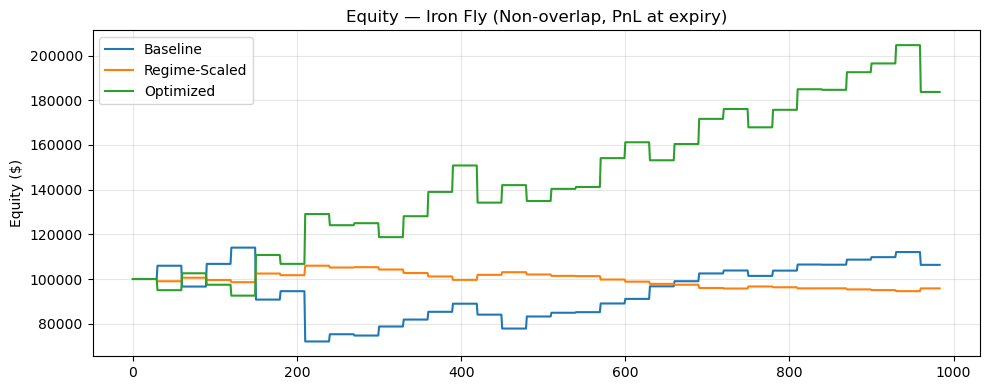

In [14]:
pd.DataFrame({
    "Baseline": eq_base, 
    "Regime-Scaled": eq_ctrl, 
    "Optimized": eq_best
}).plot(figsize=(10,4))
plt.title("Equity — {} (Non-overlap, PnL at expiry)".format("Iron Fly" if USE_WINGS else "Straddle"))
plt.ylabel("Equity ($)"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

**Figure — Equity curves (Train Set, Iron Fly, non-overlap, expiry PnL)**  
- **Baseline (blue):** always short iron fly → modest APR, large drawdowns (−37%).  
- **Regime-Scaled (orange):** handpicked long/short multipliers → smoother curve, but negative APR.  
- **Optimized (green):** short in Low/Mid, long in High with calibrated sizing → strong equity growth (+25% APR), max drawdown reduced to −11%.  

Result: regime-aware multipliers transform the profile from fragile to robust, validating the strategy logic on the training window.


In [16]:
START_TEST = "2024-01-01"
END_TEST   = (pd.Timestamp.today(tz="Asia/Bangkok").normalize()
              - pd.Timedelta(days=1)).tz_convert(None)     # yesterday local
# =========================
# Build dataset (DVOL + Spot + fwd-RV)
# =========================
dvol = load_dvol_btc_from_cdd(start=START_TEST, end=END_TEST)
btc_px = ensure_date_close(load_btc_close_from_yahoo(start=START_TEST, end=END_TEST))
spot = (btc_px.assign(spot=lambda x: pd.to_numeric(x["close"], errors="coerce"))
              .dropna(subset=["spot"])
              .sort_values("date")
              .drop_duplicates(subset=["date"], keep="last")
              [["date","spot"]])

dvol = (dvol.dropna(subset=["date","dvol"])
            .assign(dvol=lambda x: pd.to_numeric(x["dvol"], errors="coerce"))
            .dropna(subset=["dvol"])
            .sort_values("date")
            .drop_duplicates(subset=["date"], keep="last"))

df = pd.merge_asof(dvol.sort_values("date"), spot.sort_values("date"),
                   on="date", direction="backward")

rv = forward_realized_30d(spot, window_days=WINDOW_DAYS, annualizer=ANNUALIZER)
df = (df.merge(rv, on="date", how="left")
        .dropna(subset=["spot","rv_fwd_30d"])
        .reset_index(drop=True)
        .sort_values("date"))

# =========================
# Features & Regimes
# =========================
df["sigma"] = np.clip(df["dvol"] / 100.0, 1e-6, 3.0)

if FIXED_LOW_THR is not None and FIXED_HIGH_THR is not None:
    LOW_THR, HIGH_THR = float(FIXED_LOW_THR), float(FIXED_HIGH_THR)
else:
    LOW_THR  = df['dvol'].quantile(1/3)
    HIGH_THR = df['dvol'].quantile(2/3)

df["regime"] = np.where(df["dvol"] <= LOW_THR, "Low",
                 np.where(df["dvol"] <= HIGH_THR, "Medium", "High"))
print(f"Regime thresholds: Low ≤ {LOW_THR:.2f}, Medium ≤ {HIGH_THR:.2f}, High > {HIGH_THR:.2f}")
# (A) Baseline: constant size, always short (mult=+1 for all)
eq_base_test, trades_base_test, summ_base_test, byreg_base_test = run_backtest(
    df, regime_mult=None, allow_overlap=ALLOW_OVERLAP, start_equity=100_000.0
)

# (C) Optimized multipliers
eq_best_test, trades_best_test, summ_best_test, byreg_best_test = run_backtest(
    df, regime_mult=best_mult, allow_overlap=ALLOW_OVERLAP, start_equity=100_000.0
)

print("\n=== Baseline ({}; constant size) ===".format(
    "Per-regime Iron Fly/Straddle" if any(USE_WINGS_BY_REGIME.values()) else "Straddle"
))
print(summ_base_test); print("\nPnL breakdown (baseline):"); print(byreg_base_test)

print("\n=== Regime-controlled (optimized) ===")
print(summ_best_test); print("\nPnL breakdown (optimized):"); print(byreg_best_test)

Regime thresholds: Low ≤ 59.93, Medium ≤ 81.29, High > 81.29

=== Baseline (Per-regime Iron Fly/Straddle; constant size) ===
{'n_obs': 603, 'n_trades': 20, 'APR_%': 15.34, 'MDD_%': -9.093, 'EquityStart': 100000.0, 'EquityEnd': 126589.38}

PnL breakdown (baseline):
                        count     mean       sum
regime side  structure                          
Low    short iron_fly      15   993.20  14897.95
Medium short iron_fly       5  2338.29  11691.43

=== Regime-controlled (optimized) ===
{'n_obs': 603, 'n_trades': 20, 'APR_%': 30.706, 'MDD_%': -18.185, 'EquityStart': 100000.0, 'EquityEnd': 155641.47}

PnL breakdown (optimized):
                        count     mean       sum
regime side  structure                          
Low    short iron_fly      15  2163.15  32447.30
Medium short iron_fly       5  4638.83  23194.17


## Test-Set Results (Expiry PnL, Iron Fly)

**Regime thresholds (DVOL):** Low ≤ **59.93**, Medium ≤ **81.29**, High > **81.29**  
**Sample:** 603 obs, 20 non-overlapping 30D trades  
**Baseline:** always **SHORT** iron fly, **no multipliers** (constant size)  
**Optimized:** same trades, but **scaled 2× larger** (no High-DVOL trades appeared in this window)

### Performance
| Config        | Trades | APR %  | MDD %   | Calmar = APR/abs(MDD) |Equity End |
|---------------|:------:|------:|--------:|-----------:|-----------:|
| **Baseline(short IF, no mult.)**  | 20     | 15.34 | -9.09  | **1.69** |126,589.38|
| **Optimized(short IF ×2 scale)** | 20     | **30.71** | -18.19 |**1.69** |**155,641.47** |

### Interpretation
- The **optimized profile is just a scaled version of baseline** — every trade is identical, only **2× bigger**.  
- This **doubles APR** but also **doubles MDD**, leaving the **Calmar ratio unchanged**.  
- Since no High-DVOL regime trades occurred in this period, the “optimization” reduced to a **pure size increase** rather than a structural allocation change.

**Takeaway:**  
The benefit of optimization here is **not efficiency (Calmar unchanged)** but **return amplification**.  
True regime diversification (e.g., going long vol in High-DVOL) will matter only when **High regime trades** are present in the sample.

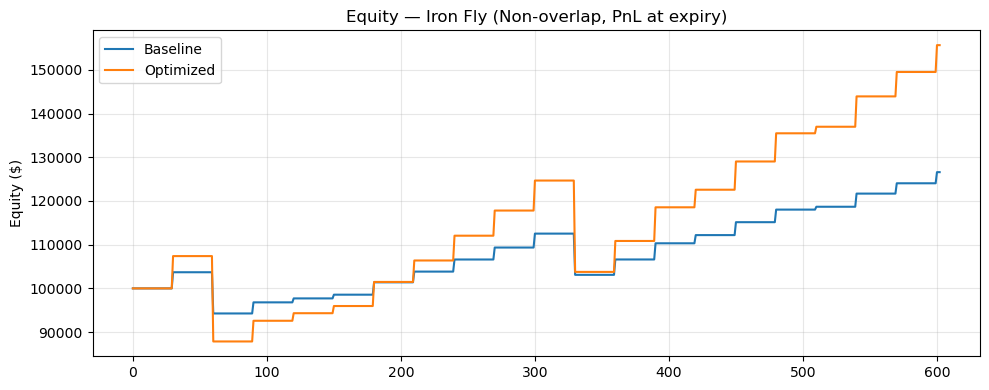

In [17]:
pd.DataFrame({
    "Baseline": eq_base_test, 
    "Optimized": eq_best_test
}).plot(figsize=(10,4))
plt.title("Equity — {} (Non-overlap, PnL at expiry)".format("Iron Fly" if USE_WINGS else "Straddle"))
plt.ylabel("Equity ($)"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

**Figure — Equity curves (Train Set, Iron Fly, non-overlap, expiry PnL)**  
- **Baseline (blue):** short iron fly with constant size. APR ≈ 15%, MDD ≈ −9%.  
- **Optimized (orange):** same trades, simply scaled 2× larger. APR ≈ 31%, MDD ≈ −18%.  
- **Calmar ratio identical (~1.7):** optimization here only amplifies both return and drawdown proportionally, since no High-DVOL trades occurred in this period.

Takeaway: In this slice, “optimization” is purely **leverage scaling**, not structural improvement. The efficiency gain (higher Calmar) would appear only when High-DVOL trades are present and regime switching alters positioning.
